### J Gene Sequence and Segment Analysis
Looking at amino acid motifs within the J gene clusters.

In [1]:
cd ..

/home/ubuntu/CVC


#### Set Environment

In [2]:
import os, sys
import pandas as pd
import seaborn as sns
import logomaker
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from cvc.embbeding_wrapper import EmbeddingWrapper


SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from lab_notebooks.utils import SC_TRANSFORMER, TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

2023-11-14 07:54:08.393135: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 07:54:08.468252: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 07:54:08.798026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 07:54:10.352746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'plots/CDR3_data_plots'

### Load the data

In [3]:
shared_df = pd.read_csv("data/400K_jGene_df.csv", engine="pyarrow")
cvc_embeddings = shared_df.loc[:, "0":"767"].values

In [7]:
colors=['gold', 'darkblue']
colors_genes = ListedColormap(sns.color_palette("Spectral", 13))

embed_wrap = EmbeddingWrapper(None, DEVICE, shared_df, embeddings = cvc_embeddings, batch_size=400, method="mean", layers=[-1], pbar=True, max_len=120) # TODO - oly to check plots

tcrb_embeddings_df = pd.DataFrame(embed_wrap.embeddings)
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/umap/distances.py:1053: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/umap/distances.py:1061: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. Se

#### J Gene Segment Calculations

Calculate, for each sequence within each cluster, the fraction of amino acids that belong to the J segment associated with that cluster in relation to the total sequence length.

In [4]:
OUTPUT_DIR = './plots/benchmarking'

In [8]:
tcrb_embeddings_adata_j_gene = embed_wrap.create_anndata()

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
j_genes = {
    'TCRBJ01-01': 'NTEAFFGQGTRLTVV',
    'TCRBJ01-02': 'NYGYTFGSGTRLTVV',
    'TCRBJ01-03': 'SGNTIYFGEGSWLTVV',
    'TCRBJ01-04': 'TNEKLFFGSGTQLSVL',
    'TCRBJ01-05': 'SNQPQHFGDGTRLSIL',
    'TCRBJ01-06': 'SYNSPLHFGNGTRLTVT',
    'TCRBJ02-01': 'SYNEQFFGPGTRLTVL',
    'TCRBJ02-02': 'NTGELFFGEGSRLTVL',
    'TCRBJ02-03': 'STDTQYFGPGTRLTVL',
    'TCRBJ02-04': 'AKNIQYFGAGTRLSVL',
    'TCRBJ02-05': 'QETQYFGPGTRLLVL',
    'TCRBJ02-06': 'SGANVLTFGAGSRLTVL',
    'TCRBJ02-07': 'SYEQYFGPGTRLTVT'
}

In [10]:
# Function to calculate sequence length
def calculate_sequence_length(sequence):
    return len(sequence)

def find_longest_consecutive_match(cdr3_sequence, j_gene_segment):
    longest_match_length = 0
    longest_match = ""

    # Iterate from the end of the cdr3_sequence
    for cdr3_index in range(len(cdr3_sequence) - 1, -1, -1):
        # Now iterate over the j_gene_segment
        for j_index in range(len(j_gene_segment)):
            # Reset match_length for each new starting j_index
            match_length = 0

            # Check if the current cdr3_index and j_index characters match
            while (cdr3_index + match_length < len(cdr3_sequence) and
                   j_index + match_length < len(j_gene_segment) and
                   cdr3_sequence[cdr3_index + match_length] == j_gene_segment[j_index + match_length]):
                match_length += 1

            # If this match is longer than the previous longest, update longest_match
            if match_length > longest_match_length:
                longest_match_length = match_length
                # Extract the actual matching string segment
                longest_match = cdr3_sequence[cdr3_index:cdr3_index + match_length]

            # If we've found a match, no need to check further for this cdr3_index, go to the next
            if match_length > 0:
                break

    return longest_match_length, longest_match

In [11]:
# Add sequence length column
tcrb_embeddings_adata_j_gene.obs['sequence_length'] = tcrb_embeddings_adata_j_gene.obs['Sequences'].apply(calculate_sequence_length)

In [12]:
# Add J gene segment column
tcrb_embeddings_adata_j_gene.obs['j_gene_segment'] = tcrb_embeddings_adata_j_gene.obs['jGeneName'].apply(lambda j_gene: j_genes[j_gene])

In [13]:
# Define a helper function to apply our matching function and capture results
def apply_matching(row):
    longest_match_length, longest_match = find_longest_consecutive_match(row['Sequences'], row['j_gene_segment'])
    return pd.Series([longest_match_length, longest_match])

# Apply the matching function to each row in the .obs DataFrame
matches = tcrb_embeddings_adata_j_gene.obs.apply(apply_matching, axis=1)
tcrb_embeddings_adata_j_gene.obs['longest_match_length'], tcrb_embeddings_adata_j_gene.obs['longest_match'] = matches[0], matches[1]

In [184]:
# Calculate the fraction of the CDR3 sequence that the longest match represents
tcrb_embeddings_adata_j_gene.obs['longest_match_fraction'] = (tcrb_embeddings_adata_j_gene.obs['longest_match_length'] / tcrb_embeddings_adata_j_gene.obs['sequence_length'] * 100).round(2)

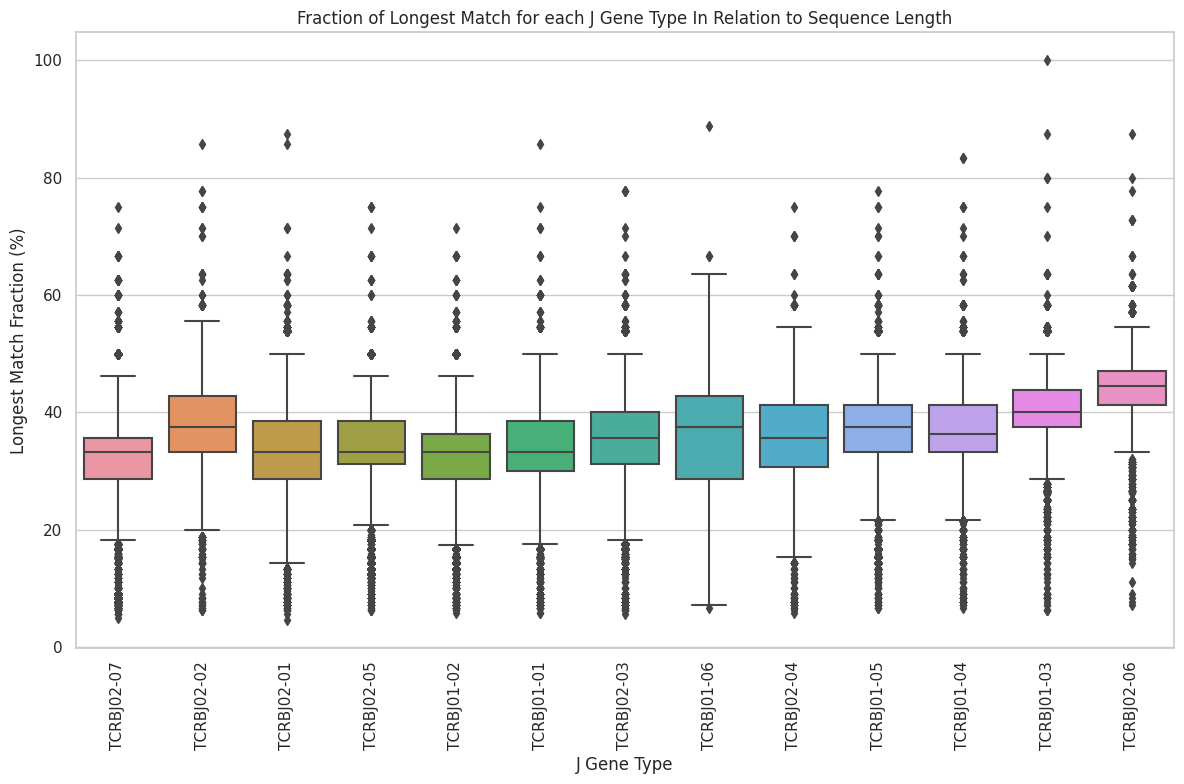

In [201]:
# Create a boxplot to visualize the fraction for each J gene type
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.boxplot(
    x='jGeneName',
    y='longest_match_fraction',
    data=tcrb_embeddings_adata_j_gene.obs
)

plt.xticks(rotation=90)  # Rotate the x labels if they overlap
plt.title('Fraction of Longest Match for each J Gene Type In Relation to Sequence Length')
plt.xlabel('J Gene Type')
plt.ylabel('Longest Match Fraction (%)')
plt.tight_layout()  # Adjust the layout to fit everything nicely

# Save the figure
logo_fig_path = os.path.join('./plots/benchmarking', 'fraction_j_gene_segments.svg')
plt.savefig(logo_fig_path, dpi=1200)
plt.show()

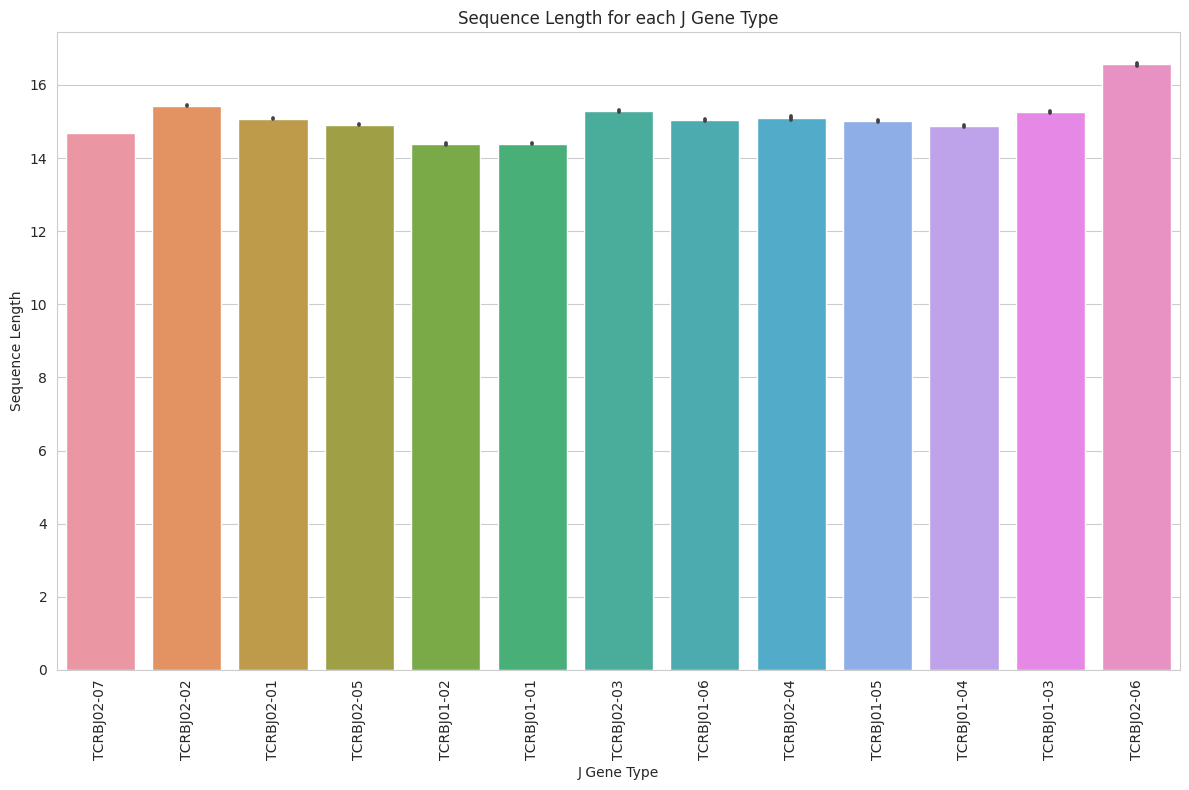

In [14]:
# plot the average sequence length for each J gene type
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.barplot(
    x='jGeneName',
    y='sequence_length',
    data=tcrb_embeddings_adata_j_gene.obs
)

plt.xticks(rotation=90)  # Rotate the x labels if they overlap
plt.title('Sequence Length for each J Gene Type')
plt.xlabel('J Gene Type')
plt.ylabel('Sequence Length')
plt.tight_layout()  # Adjust the layout to fit everything nicely

# Save the figure
logo_fig_path = os.path.join('./plots/benchmarking', 'j_gene_length_segments.svg')
plt.savefig(logo_fig_path, dpi=1200)

plt.show()

#### Logo for each J gene type

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


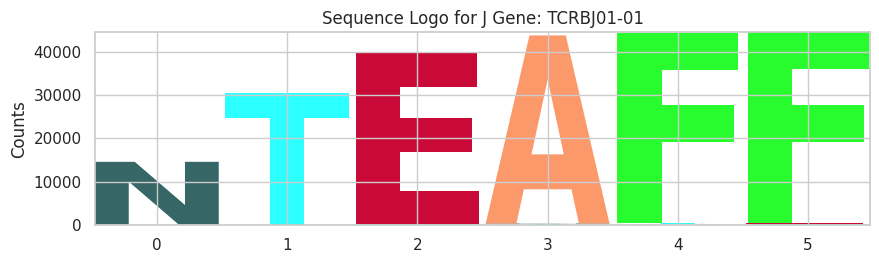

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


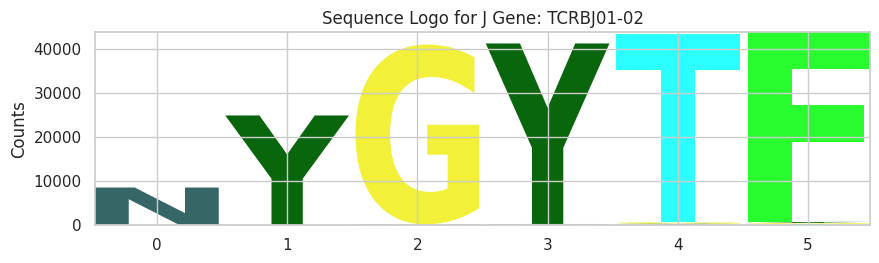

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


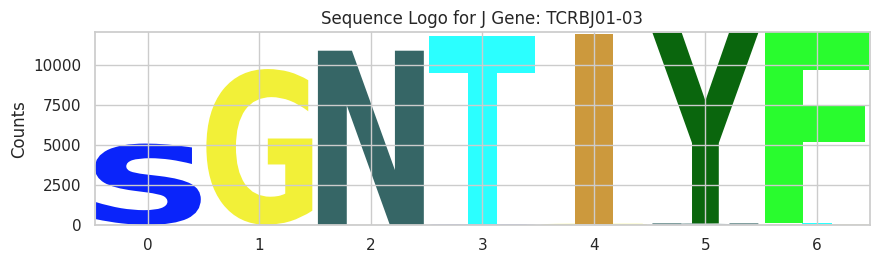

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


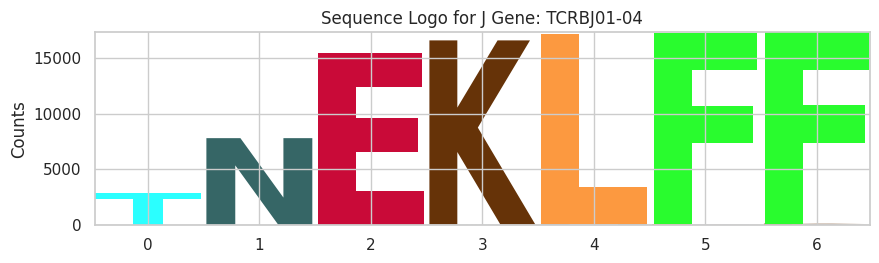

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


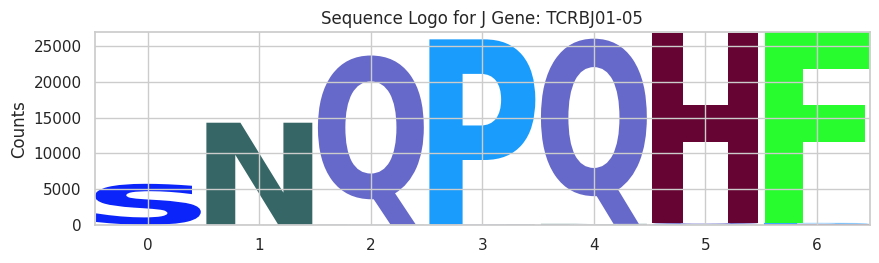

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


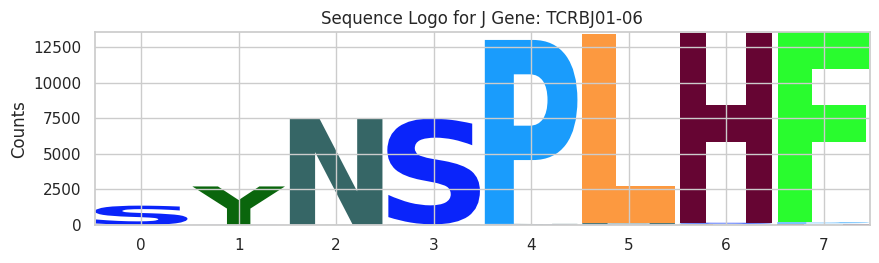

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


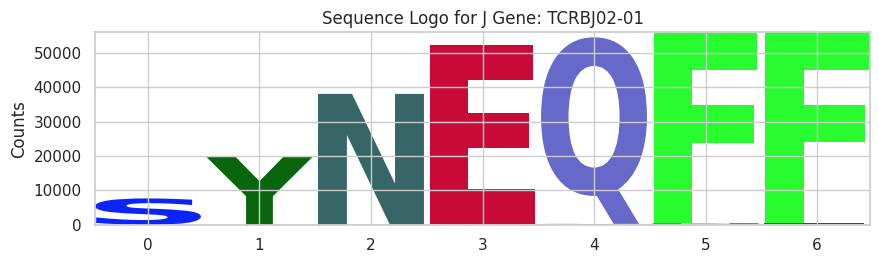

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


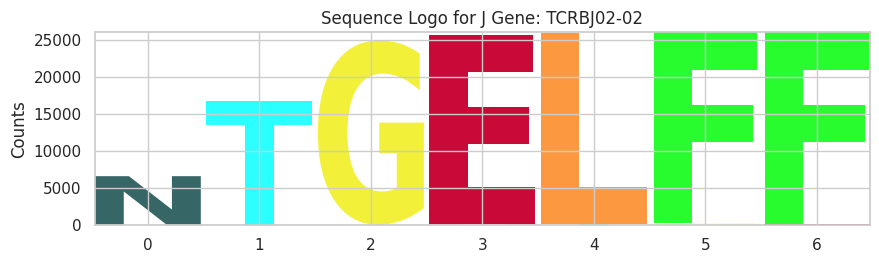

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


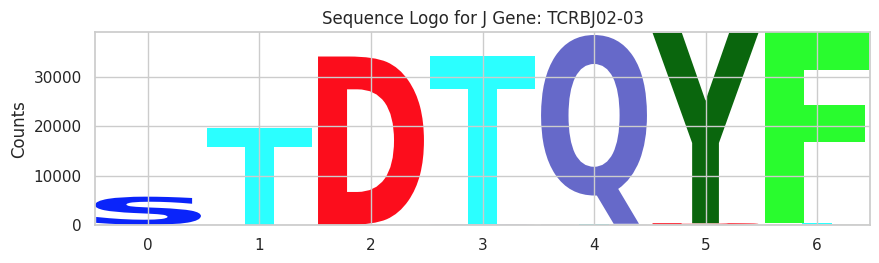

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


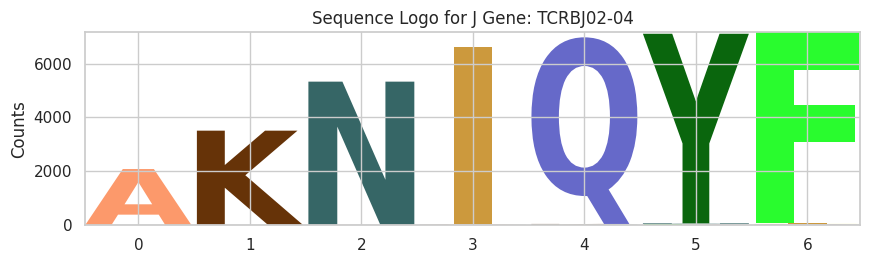

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


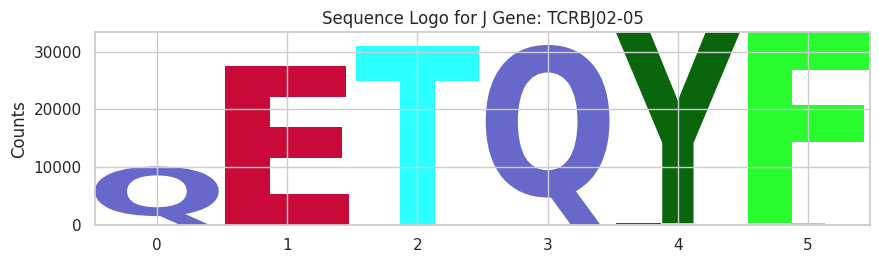

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


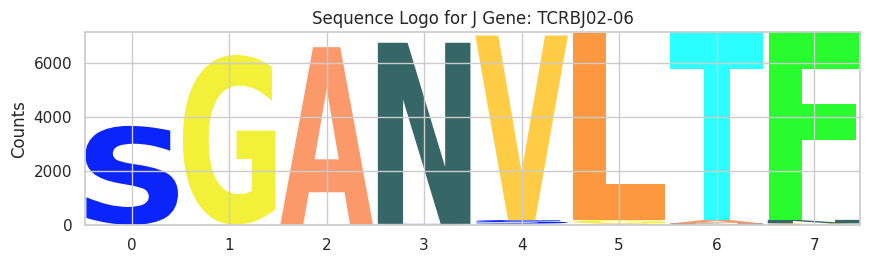

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


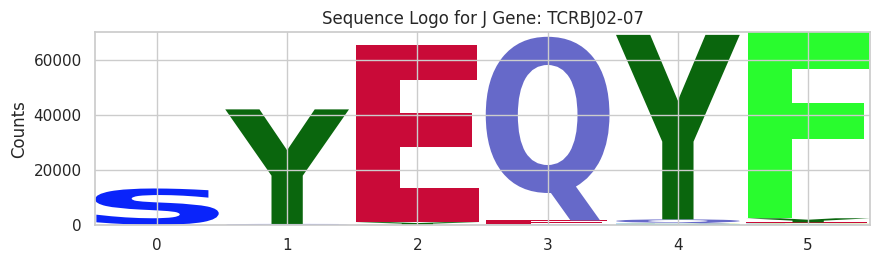

In [193]:
# Group the 'longest_match' sequences by 'j_gene' and create a logo for each group
for j_gene, group in tcrb_embeddings_adata_j_gene.obs.groupby('jGeneName'):
    # Get a list of all the longest match sequences for each group
    all_sequences = group['longest_match'].tolist()

    # Skip if there are no sequences
    if not all_sequences:
        continue

    # Find the length of the longest sequence
    max_length = max(len(seq) for seq in all_sequences)

    # Pad each sequence to the length of the longest sequence
    padded_sequences = [seq.rjust(max_length, '-') for seq in all_sequences]

    # Create a logo for each non-empty set of sequences
    logo_df = logomaker.alignment_to_matrix(sequences=padded_sequences, to_type='counts', characters_to_ignore='-')

    # Create the sequence logo
    logo = logomaker.Logo(logo_df, color_scheme='skylign_protein')

    # Customize the logo
    logo.ax.set_ylabel('Counts')
    logo.ax.set_title(f'Sequence Logo for J Gene: {j_gene}')

    # Show the logo
    plt.show()

#### Find Motifs and Create Sequence Logos

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


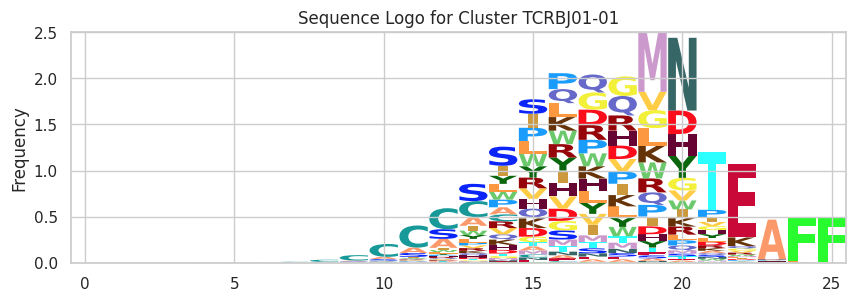

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


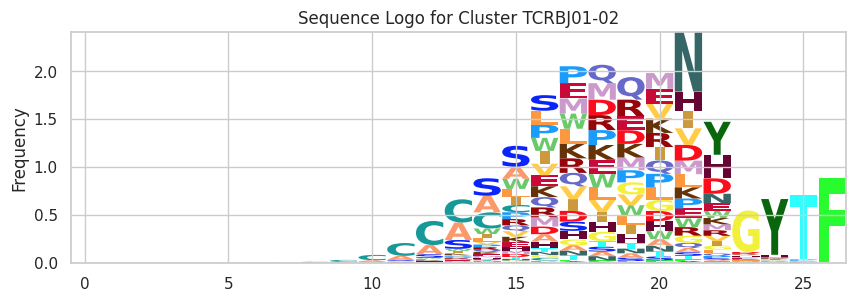

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


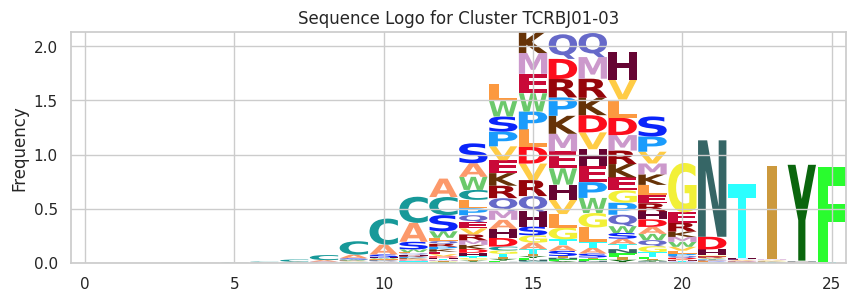

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


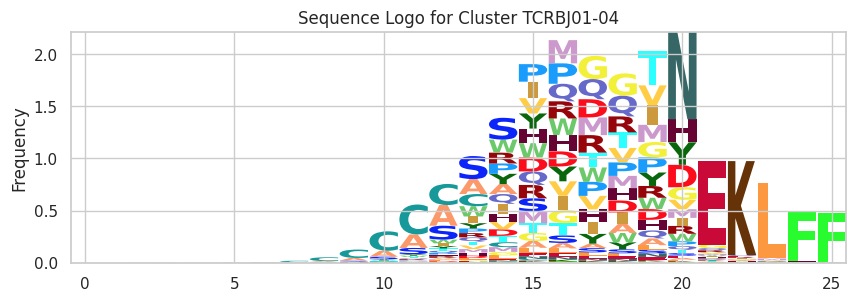

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


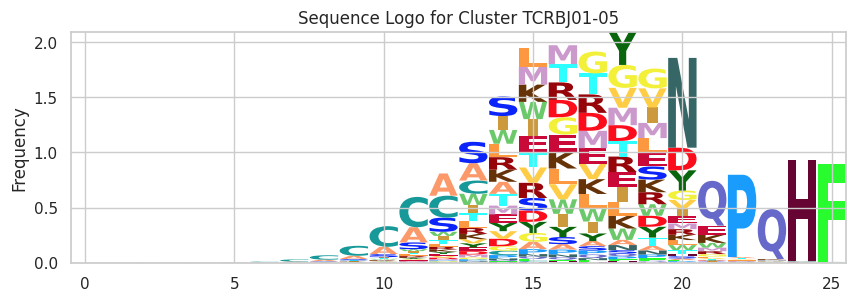

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


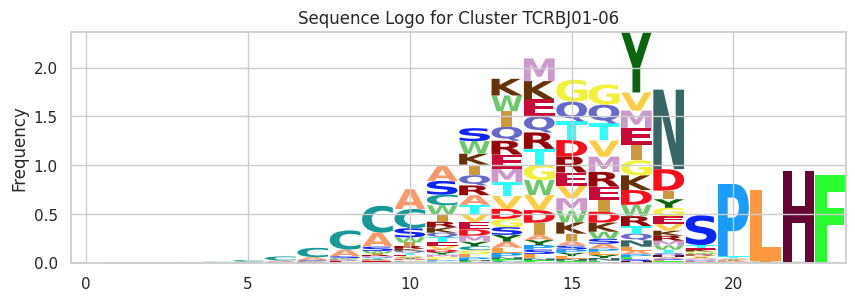

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


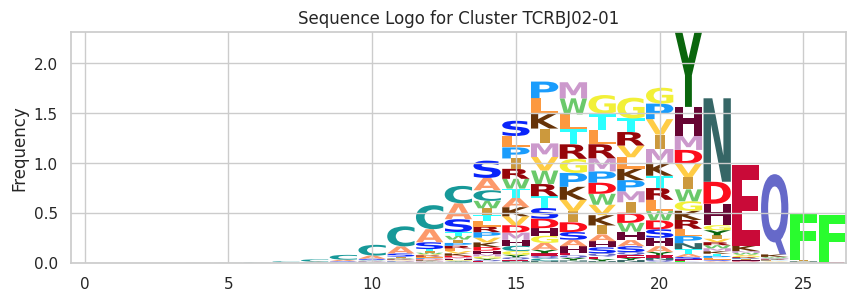

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


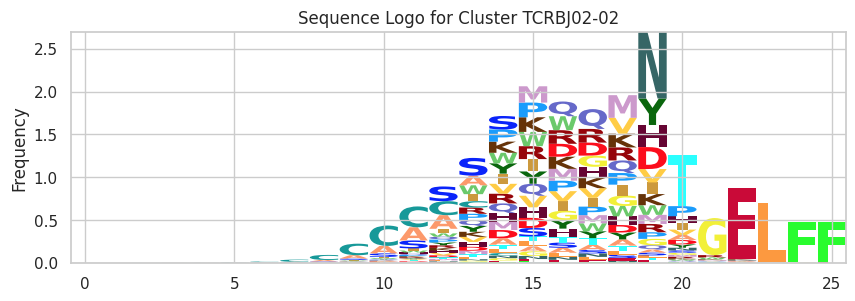

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


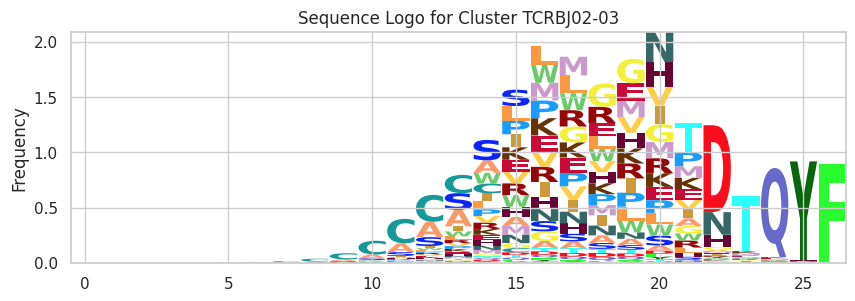

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


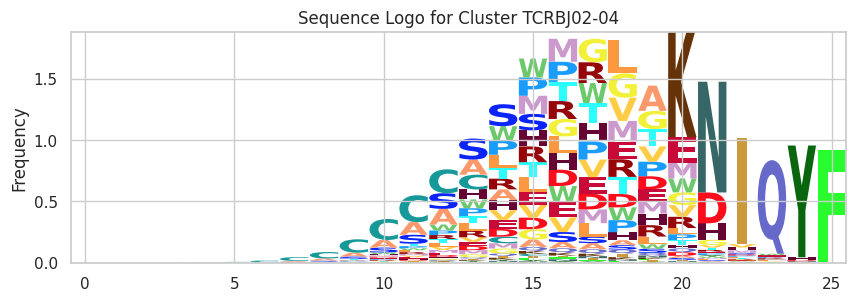

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


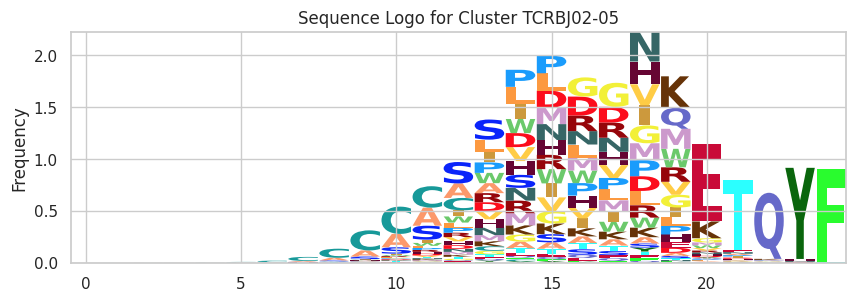

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


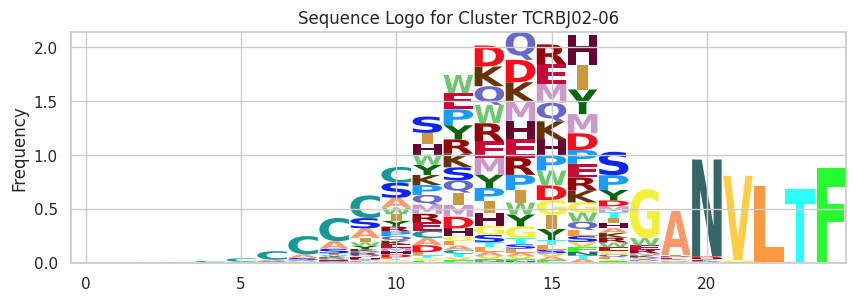

/home/ubuntu/miniconda3/envs/cvc_env/lib/python3.8/site-packages/logomaker/src/matrix.py:584: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  counts_df.loc[:, c] = tmp_mat.sum(axis=0).T


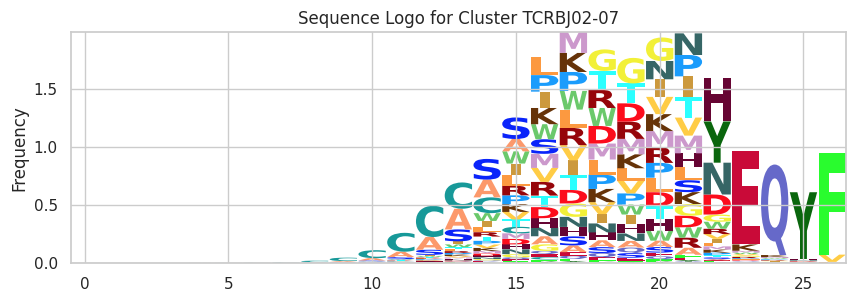

In [164]:
# Define your OUTPUT_DIR where you want to save the logos
OUTPUT_DIR = './plots/benchmarking/cluster_logos_2'
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Ensure the directory exists

# Convert the relevant AnnData observations to a DataFrame
sequences_df = pd.DataFrame({
    'sequence': tcrb_embeddings_adata.obs['Sequences'],
    # 'cluster': tcrb_embeddings_adata.obs['kmeans_clusters']
    'cluster': tcrb_embeddings_adata.obs['jGeneName']
})

# Group sequences by cluster and get a list of sequences for each cluster
clustered_sequences = sequences_df.groupby('cluster')['sequence'].apply(list)

# Now, iterate over each cluster, create sequence logos, display, and save the figures
for cluster_id, sequences in clustered_sequences.items():
    # Find the maximum length of sequences in this cluster
    max_seq_length = max(len(seq) for seq in sequences)

    # Pad sequences with '-' on the left to ensure last amino acids align
    padded_sequences = [seq.rjust(max_seq_length, '-') for seq in sequences]

    # Calculate position weight matrix for the padded sequences in this cluster
    counts_mat = logomaker.alignment_to_matrix(sequences=padded_sequences, to_type='counts')

    # Normalize the counts to get the position frequency matrix
    pwm = counts_mat / counts_mat.sum(axis=0)

    # Create the logo object
    logo = logomaker.Logo(pwm, figsize=(10, 3), color_scheme='skylign_protein')

    # Configure the logo object
    logo.ax.set_ylabel('Frequency')
    logo.ax.set_title(f'Sequence Logo for Cluster {cluster_id}')

    # Save the figure
    logo_fig_path = os.path.join(OUTPUT_DIR, f'cluster_{cluster_id}_logo.svg')
    plt.savefig(logo_fig_path, dpi=1200)

    # Display the figure
    plt.show()